In [1]:
import fsps
import pickle
import numpy as np 
import astropy.units as u
from astropy import units as U
# -- gqp_mc --
from gqp_mc import fitters as Fitters
# -- plotting --
import matplotlib as mpl 
import matplotlib.pyplot as plt 
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False
%matplotlib inline

In [2]:
speculate = Fitters.iSpeculator()

In [3]:
# Generate some random SED and sort out wavelength selection
theta = np.load('_theta.npy')
_wave, sspLum = np.load('fsps_sspLum.npy')

In [4]:
spectrum = speculate._emulator(theta)

No handles with labels found to put in legend.


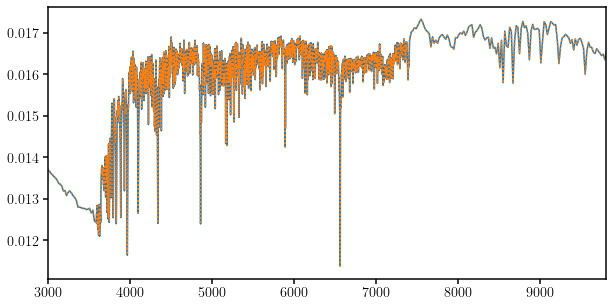

In [5]:
fig = plt.figure(figsize=(10,5))
sub = plt.subplot(111)
sub.plot(speculate._emu_wave, spectrum)
sub.plot(_wave, sspLum, ls=':')
sub.set_xlim(3e3, 9800.)
#sub.set_ylim(-5.5,-4.25)
sub.legend(loc='upper right', fontsize=20)